In [11]:
from pathlib import Path

import numpy as np
import pypulseq as pp
import re
from bmc.utils.seq.write import write_seq

import matplotlib.pyplot as plt

In [12]:
wdir = Path().resolve().parent
folder = wdir / "seq_lib" / "exchange_variation"

sys = pp.Opts(
    max_grad=12000,
    grad_unit="mT/m",
    max_slew=1e9,
    slew_unit="T/m/s",
    rf_ringdown_time=0,
    rf_dead_time=0,
    rf_raster_time=1e-6,
    gamma=42576400,
    grad_raster_time=1e-6,
)
# general settings
AUTHOR = "DANIEL MIKSCH"
FLAG_PLOT_SEQUENCE = True  # plot preparation block?
FLAG_CHECK_TIMING = True  # perform a timing check at the end of the sequence?
FLAG_POST_PREP_SPOIL = True  # add spoiler after preparation block?

defs: dict = {}

### Definitions

In [13]:
seqid = [f"tex_{i}ms" for i in range(2, 502, 2)]
# seqid = [f"tex_{i}ms_minus" for i in range(2, 502, 2)]


defs["a"] = 90 # alpha in degrees
defs["b0"] = 17  # B0 [T]
defs["m0_offset"] = 100  # m0 offset [ppm]
defs["n_ETM"] = 10  # number of ETMs

#rf settings
flip_angle_90 = np.radians(defs['a'])
flip_angle_180 = np.radians(180)
t_pulse = 2e-3 

#gradient settings
spoil_amp = 0.109 * sys.max_grad  # Hz/m

crush_amp = 0.99 * sys.max_grad  # Hz/m

rise_time = 0.05e-3 #(spoil_amp / GAMMA_HZ) / sys.max_slew  # spoiler rise time in seconds
spoil_dur = 0.5e-3  # complete spoiler duration in seconds
exchange_dur = 8e-3
rephase_dur = 0.5e-3

#delay settings

exchange_time = []
for name in seqid:
    match = re.search(r'(\d+)ms', name)  # Suche nach einer Zahl vor "ms"
    if match:
        time_in_ms = int(match.group(1))  # Extrahiere die Zahl
        time_in_s = time_in_ms / 1000     # Konvertiere in Sekunden
        exchange_time.append(time_in_s)
delay_inter_etm = pp.make_delay(0.5e-3)

delay_exchange = [pp.make_delay(i) for i in exchange_time]

test_delay = pp.make_delay(1e-3)

#adc
pseudo_adc = pp.make_adc(num_samples=1, duration=1e-3)

print(exchange_time)


[0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032, 0.034, 0.036, 0.038, 0.04, 0.042, 0.044, 0.046, 0.048, 0.05, 0.052, 0.054, 0.056, 0.058, 0.06, 0.062, 0.064, 0.066, 0.068, 0.07, 0.072, 0.074, 0.076, 0.078, 0.08, 0.082, 0.084, 0.086, 0.088, 0.09, 0.092, 0.094, 0.096, 0.098, 0.1, 0.102, 0.104, 0.106, 0.108, 0.11, 0.112, 0.114, 0.116, 0.118, 0.12, 0.122, 0.124, 0.126, 0.128, 0.13, 0.132, 0.134, 0.136, 0.138, 0.14, 0.142, 0.144, 0.146, 0.148, 0.15, 0.152, 0.154, 0.156, 0.158, 0.16, 0.162, 0.164, 0.166, 0.168, 0.17, 0.172, 0.174, 0.176, 0.178, 0.18, 0.182, 0.184, 0.186, 0.188, 0.19, 0.192, 0.194, 0.196, 0.198, 0.2, 0.202, 0.204, 0.206, 0.208, 0.21, 0.212, 0.214, 0.216, 0.218, 0.22, 0.222, 0.224, 0.226, 0.228, 0.23, 0.232, 0.234, 0.236, 0.238, 0.24, 0.242, 0.244, 0.246, 0.248, 0.25, 0.252, 0.254, 0.256, 0.258, 0.26, 0.262, 0.264, 0.266, 0.268, 0.27, 0.272, 0.274, 0.276, 0.278, 0.28, 0.282, 0.284, 0.286, 0.288, 0.29, 0.292, 0.294, 0

In [14]:
defs["offsets_ppm"] = np.array([defs["m0_offset"]])
defs["num_meas"] = defs["offsets_ppm"].size  # number of repetition
defs["seq_id_string"] = seqid  # unique seq id
seq_filename = [seqid[i] + ".seq" for i in range(len(seqid))]
GAMMA_HZ = sys.gamma * 1e-6
defs["freq"] = defs["b0"] * GAMMA_HZ  # Larmor frequency [Hz]

### RF events

In [15]:
rf_90 = pp.make_gauss_pulse(
    flip_angle=flip_angle_90,
    system=sys,
    duration=t_pulse,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)

rf_90_re = pp.make_gauss_pulse(
    flip_angle=flip_angle_90,
    system=sys,
    duration=t_pulse,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=np.radians(180),
    return_gz=False)

rf_90_water = pp.make_gauss_pulse(
    flip_angle=np.radians(90),
    system=sys,
    duration=t_pulse,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)

rf_180 = pp.make_gauss_pulse(
    flip_angle=flip_angle_180,
    system=sys,
    duration=t_pulse,
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)

### Gradient events

In [16]:
def create_trapezoid(amplitude, duration, rise_time, dt=sys.grad_raster_time):
    if 2 * rise_time > duration:
        raise ValueError("Die Anstiegs- und Abfallzeit zusammen dürfen nicht länger als die Gesamtdauer sein.")

    # Anzahl der Samples für jede Phase
    num_rise_samples = int(rise_time / dt)  # Anzahl der Samples für die Anstiegsphase
    num_flat_samples = int((duration - 2 * rise_time) / dt)  # Anzahl der Samples für das Plateau
    total_samples = num_rise_samples * 2 + num_flat_samples  # Gesamte Anzahl der Samples

    # Trapezoid erstellen
    trapezoid = np.zeros(total_samples)

    # Anstiegsphase: Linear von 0 bis zur Amplitude
    rise = np.linspace(0, amplitude, num_rise_samples, endpoint=False)
    trapezoid[:num_rise_samples] = rise

    # Plateau: Konstante Amplitude
    trapezoid[num_rise_samples:num_rise_samples + num_flat_samples] = amplitude

    # Abfallphase: Linear von Amplitude zurück auf 0
    fall = np.linspace(amplitude, 0, num_rise_samples, endpoint=True)
    trapezoid[num_rise_samples + num_flat_samples:] = fall

    return trapezoid

In [17]:
trapeziod_spoil = create_trapezoid(spoil_amp, spoil_dur, rise_time)
trapeziod_rephase = create_trapezoid(spoil_amp, rephase_dur, rise_time)
trapeziod_spoil_minus = create_trapezoid(-spoil_amp, spoil_dur, rise_time)
trapeziod_exchange = create_trapezoid(crush_amp, exchange_dur, rise_time)

gz_spoil = pp.make_arbitrary_grad(channel='z', 
                             system=sys, 
                             waveform=trapeziod_spoil,
                             )

gz_rephase = pp.make_arbitrary_grad(channel='z', 
                             system=sys, 
                             waveform=trapeziod_rephase,
                             )

gz_exchange = pp.make_arbitrary_grad(channel='z',
                                system=sys,
                                waveform=trapeziod_exchange,
                                )

gz_spoil_minus = pp.make_arbitrary_grad(channel='z', 
                             system=sys, 
                             waveform=trapeziod_spoil_minus,
                             )

In [18]:
# dt = sys.grad_raster_time  # Zeitauflösung

# trapezoid = create_trapezoid(-spoil_amp, spoil_dur, rise_time, dt)

# # Plot
# import matplotlib.pyplot as plt
# time = np.arange(len(trapezoid)) * dt  # Zeitachse
# plt.plot(time, trapezoid)
# plt.title("Trapezoid with Slopes")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.grid()
# plt.show()
# spoil_amp

### Sequence

In [19]:


# rf_90.phase_offset = np.radians(-90)

for index, exchange in enumerate(delay_exchange):
    seq = pp.Sequence()
    offsets_hz = defs["offsets_ppm"] * defs["freq"] 
    rf_90.freq_offset = offsets_hz[0]
    rf_90_re.freq_offset = offsets_hz[0]

    for i in range(defs["n_ETM"]):
        seq.add_block(rf_90)
        seq.add_block(gz_spoil)
        seq.add_block(rf_90)

        seq.add_block(exchange)
        
    seq.add_block(rf_90_water)
    seq.add_block(gz_spoil)
    seq.add_block(pseudo_adc)

    if FLAG_CHECK_TIMING:
        ok, error_report = seq.check_timing()
    if ok:
        print("\nTiming check passed successfully")
    else:
        print("\nTiming check failed! Error listing follows\n")
        print(error_report)

    write_seq(seq=seq, seq_defs=defs, filename=folder / seq_filename[index], author=AUTHOR, use_matlab_names=True)


Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check passed successfully

Timing check 

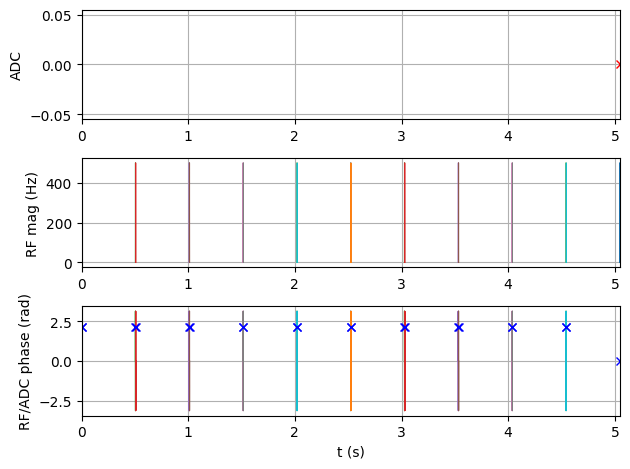

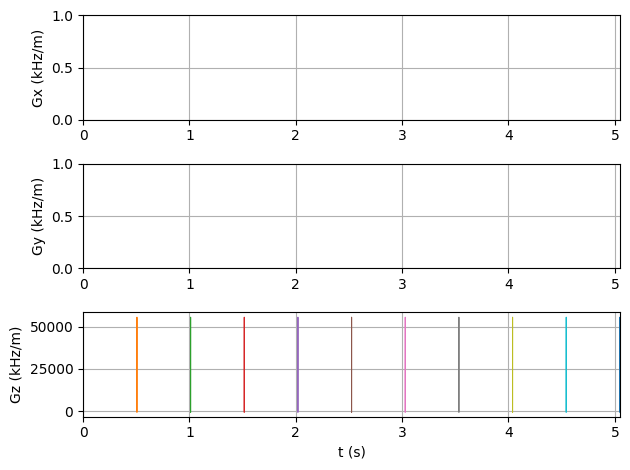

In [20]:
# if FLAG_CHECK_TIMING:
#     ok, error_report = seq.check_timing()
# if ok:
#     print("\nTiming check passed successfully")
# else:
#     print("\nTiming check failed! Error listing follows\n")
#     print(error_report)

if FLAG_PLOT_SEQUENCE:
    seq.plot() #time_range=[0.00, .03]